In [1]:
import ipywidgets as widgets

path = widgets.Text(
    value = 'C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\',
    placeholder='Type something',
    description='File path:',
    disabled=False
)


tiff_path = widgets.Text(
    value = 'C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\',
    placeholder='Type something',
    description='tiff stack:',
    disabled=False
)

display(path)
display(tiff_path)


Text(value='C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\', description='File path:', placeho…

Text(value='C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\', description='tiff stack:', placeh…

In [74]:
%matplotlib inline
import vtk
from vtk.numpy_interface import dataset_adapter as dsa
from scipy.optimize import minimize
from scipy.spatial import distance
import ipyvolume as ipv
import numpy as np
from skimage import io, filters
import matplotlib.pyplot as plt
import matplotlib.tri as tri

reader = vtk.vtkSTLReader()
reader.SetFileName(path.value)
reader.Update()

tiff_reader = vtk.vtkTIFFReader()
tiff_reader.SetFileName(tiff_path.value)
tiff_reader.Update()


In [75]:
vtkImage = tiff_reader.GetOutput()
dim = vtkImage.GetDimensions()
wrap = dsa.WrapDataObject(vtkImage)

stack = wrap.PointData['Tiff Scalars'].reshape(dim,order='F')


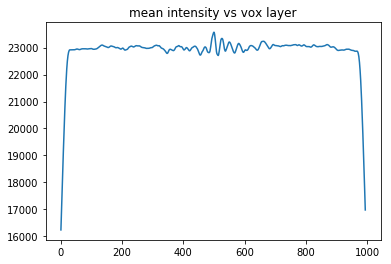

In [76]:
mean_z_intensity = np.mean(stack, axis = (0,1))

fig, ax = plt.subplots()
ax.set_title('mean intensity vs vox layer')
ax.plot(range(mean_z_intensity.shape[0]), mean_z_intensity)
plt.show()

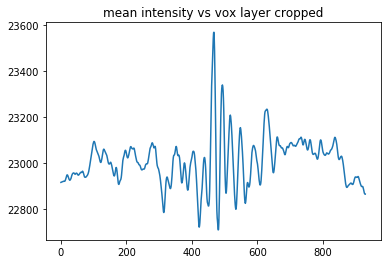

In [77]:
from rpy2.robjects import FloatVector
from rpy2.robjects.packages import importr

cpt = importr('changepoint')

cpm_result = cpt.multiple_mean_norm(FloatVector(mean_z_intensity),"BinSeg","MBIC",0,2,True,True,1)

change_pts = cpt.cpts(cpm_result)

bot = int(change_pts[0])+ 20
top = int(change_pts[1])- 20
cut_warp = mean_z_intensity[bot:top]

fig, ax = plt.subplots()
ax.set_title('mean intensity vs vox layer cropped')
ax.plot(range(cut_warp.shape[0]), cut_warp)
plt.show()

In [78]:
bd = vtkImage.GetExtent()
voi = [bd[0],bd[1],bd[2],bd[3],bot,top]
crop_image = vtk.vtkExtractVOI()
crop_image.SetVOI(voi)
crop_image.SetInputConnection(tiff_reader.GetOutputPort())
crop_image.SetSampleRate(1,1,1)
crop_image.Update()

In [79]:
mesh = dsa.WrapDataObject(reader.GetOutput())
pt_cloud = mesh.GetPoints()

In [80]:
z_l = np.min(pt_cloud[:,2])
z_u = np.max(pt_cloud[:,2])
center = mesh.GetCenter()
z = z_u - z_l +2 

In [81]:

def opt_cyl(c,z,z_l,X,r):
    ray = np.array([[c[0]-c[2],c[1]-c[3],z]])
    X_v = X - np.array([c[2],c[3],z_l])
    dist_ar = distance.cdist(ray,X)
    diff = np.abs(dist_ar-r)
    return np.mean(diff)

x_0 = np.array([center[0],center[1],center[0],center[1]])
bd = ((mesh.GetBounds()[0:2]),(mesh.GetBounds()[2:4]),(mesh.GetBounds()[0:2]),(mesh.GetBounds()[2:4]))
result = minimize(opt_cyl,x_0,args=(z,z_l,pt_cloud,5.8/2),bounds = bd)


In [82]:
from numpy import linalg as la

top_v = np.array([result.x[0],result.x[1],z_u])
rotation_ori = np.array([result.x[2],result.x[3],z_l])

ray = top_v-rotation_ori
vert = np.array([center[0],center[1],1])

angle = np.arccos(np.vdot(ray,vert)/(la.norm(ray)*la.norm(vert)))
rotate = vtk.vtkTransform()
rotate.RotateWXYZ(np.rad2deg(angle),rotation_ori)

transform_filter = vtk.vtkTransformPolyDataFilter()
transform_filter.SetInputConnection(reader.GetOutputPort())
transform_filter.SetTransform(rotate)
transform_filter.Update()

rotated_mesh = dsa.WrapDataObject(transform_filter.GetOutput())

cyl_to_cartesian = vtk.vtkCylindricalTransform()
cartesian_to_cyl = cyl_to_cartesian.GetInverse()

coord_transform = vtk.vtkTransformPolyDataFilter()
coord_transform.SetTransform(cartesian_to_cyl)
coord_transform.SetInputConnection(transform_filter.GetOutputPort())
coord_transform.Update()

In [83]:
resampler = vtk.vtkImageReslice()
resampler.SetResliceTransform(rotate)
resampler.SetInputConnection(crop_image.GetOutputPort())
resampler.Update()

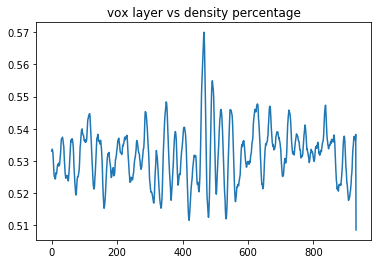

In [84]:
import numpy.ma as ma
from skimage.filters import threshold_otsu

def density(im):
    masked = ma.masked_where(im == 0, im)
    thresh = threshold_otsu(masked.compressed())

    binary = im < thresh

    new_im = np.copy(im)

    new_im[binary] = 0
    new_im[~binary] = 1

    n_masked = ma.masked_where(im==0,new_im)
    
    return np.mean(n_masked,axis=(0,1))

dim = resampler.GetOutput().GetDimensions()
vtk_cropped_rs_w = dsa.WrapDataObject(resampler.GetOutput())
cropped_rs = vtk_cropped_rs_w.PointData['Tiff Scalars'].reshape(dim,order='F')

z_mean = density(cropped_rs)
fig, ax = plt.subplots()
ax.set_title('vox layer vs density percentage')
ax.plot(range(cropped_rs.shape[2]), z_mean)
plt.show()

In [92]:
mesh_cyl = dsa.WrapDataObject(coord_transform.GetOutput())
pt_cloud_cyl = mesh_cyl.GetPoints()

In [86]:
import numpy.ma as ma

def interpolate(pt_cloud,x,y):
    triang = tri.Triangulation(pt_cloud[:,1], pt_cloud[:,2])
    interpolator = tri.LinearTriInterpolator(triang, pt_cloud[:,0])
    return interpolator(Xi, Yi)    

norm_pt_cloud_na = np.copy(pt_cloud_cyl)
norm_pt_cloud_na[:,0] = norm_pt_cloud_na[:,0] - 5.8/2

z_res = 200
theta_res = 300
r_res = 5

r_delta_max = np.max(norm_pt_cloud_na[:,0])
r_delta_min = np.min(norm_pt_cloud_na[:,0])
zz = np.linspace(-1.00,1.00,z_res)
Xi, Yi = np.meshgrid(np.linspace(0,2*np.pi,theta_res),zz)
r = interpolate(norm_pt_cloud_na,Xi, Yi)


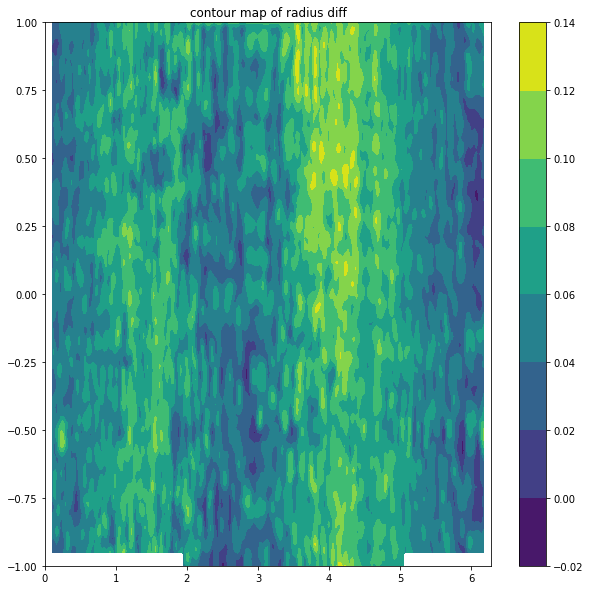

In [87]:
from skimage.filters import gaussian
smoothed = gaussian(r,sigma = 1)
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title('contour map of radius diff')
cf = ax.contourf(Xi, Yi,smoothed)
fig.colorbar(cf)
plt.show()

In [88]:
dist_s = np.zeros((z_res,r_res))
bin_edge = np.linspace(r_delta_min,r_delta_max,r_res+1)
for i in range(z_res):
    bined, bin_edge=np.histogram(smoothed[i,:],bins=bin_edge)
    dist_s[i] = bined

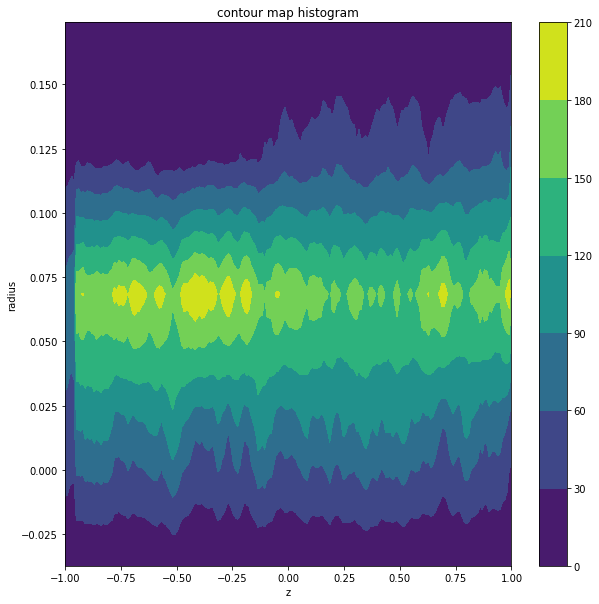

In [89]:
fig,ax = plt.subplots(figsize=(10,10))
Zi,bini = np.meshgrid(zz,np.linspace(r_delta_min,r_delta_max,r_res))
cf = ax.contourf(Zi,bini,dist_s.T)
fig.colorbar(cf)
ax.set_title('contour map histogram')
ax.set_xlabel("z")
ax.set_ylabel("radius")
plt.show()


In [90]:
from scipy.stats import norm

gauss_dist = np.zeros((dist_s.shape[0],2))

for i in range(dist_s.shape[0]):
    gauss_dist[i] = norm.fit(dist_s[i])
    

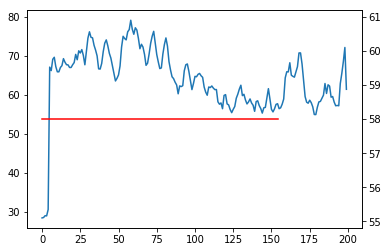

In [91]:
fig,ax = plt.subplots()
ax.plot(gauss_dist[:,1])
ax2 = ax.twinx()
ax2.plot(gauss_dist[20:175,0],color = 'r')
plt.show()